In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

from tqdm import tqdm

In [2]:
identifiers = ['player_name', 'club_involved_name', 'season']
player_var = ['age', 'wage', 'value', 'cost', 'ratingFM', 'potential', 'injprone', 'afterloan', 'contract']
team_var = ['reputation', 'balance', 'wagebudget', 'trainingfacilities', 'youthfacilities', 'youthacademy', 'stadiumcap', 'avgattendance']
stats_var = ['gamesPlayed', 'subedOn', 'MotM', 'ratingWS']
offensive_var = ['goalsScored', 'assists', 'shots', 'passes', 'passesSuccess', 'aerialsWon', 'keyPasses', 'dribbles', 'offsides', 'dispossessed', 'badTouch', 'crosses', 'longBalls', 'throughBalls']
defensive_var = ['yellow', 'red', 'tackles', 'interceptions', 'fouls', 'offsidesProvoked', 'clearances', 'blockedPass', 'ownGoal']
previous_var = ['ATaction', 'ATgoals', 'ATassists', 'ATshots', 'ATpasses', 'ATpassesSuccess', 'ATtackles', 'ATinterceptions', 'ATMotM', 'ATrating', 'CLaction', 'CLgoals', 'CLassists', 'CLMotM', 'CLrating', 'ELaction', 'ELgoals', 'ELassists', 'ELMotM', 'ELrating']
pos_var = ['GK', 'DEF', 'MID', 'STR', 'Wing', 'Central']
external_var = ['year', 'GDP', 'CountryPopulation', 'UEFAranking', 'eurgbp']
features = player_var + team_var + stats_var + offensive_var + defensive_var + previous_var + pos_var + external_var
labels = ['fee_cleaned', 'fee_log']

removed_features = []

In [3]:
external_test_validation_split = 0.5
internal_test_validation_split = 0.5

In [4]:
df = pd.read_csv('data/data.csv')
train_df = df.sample(int(external_test_validation_split * len(df)), random_state=0)

In [5]:
clf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
clf.fit(train_df[features], train_df['fee_log'])
feature_importances = clf.feature_importances_

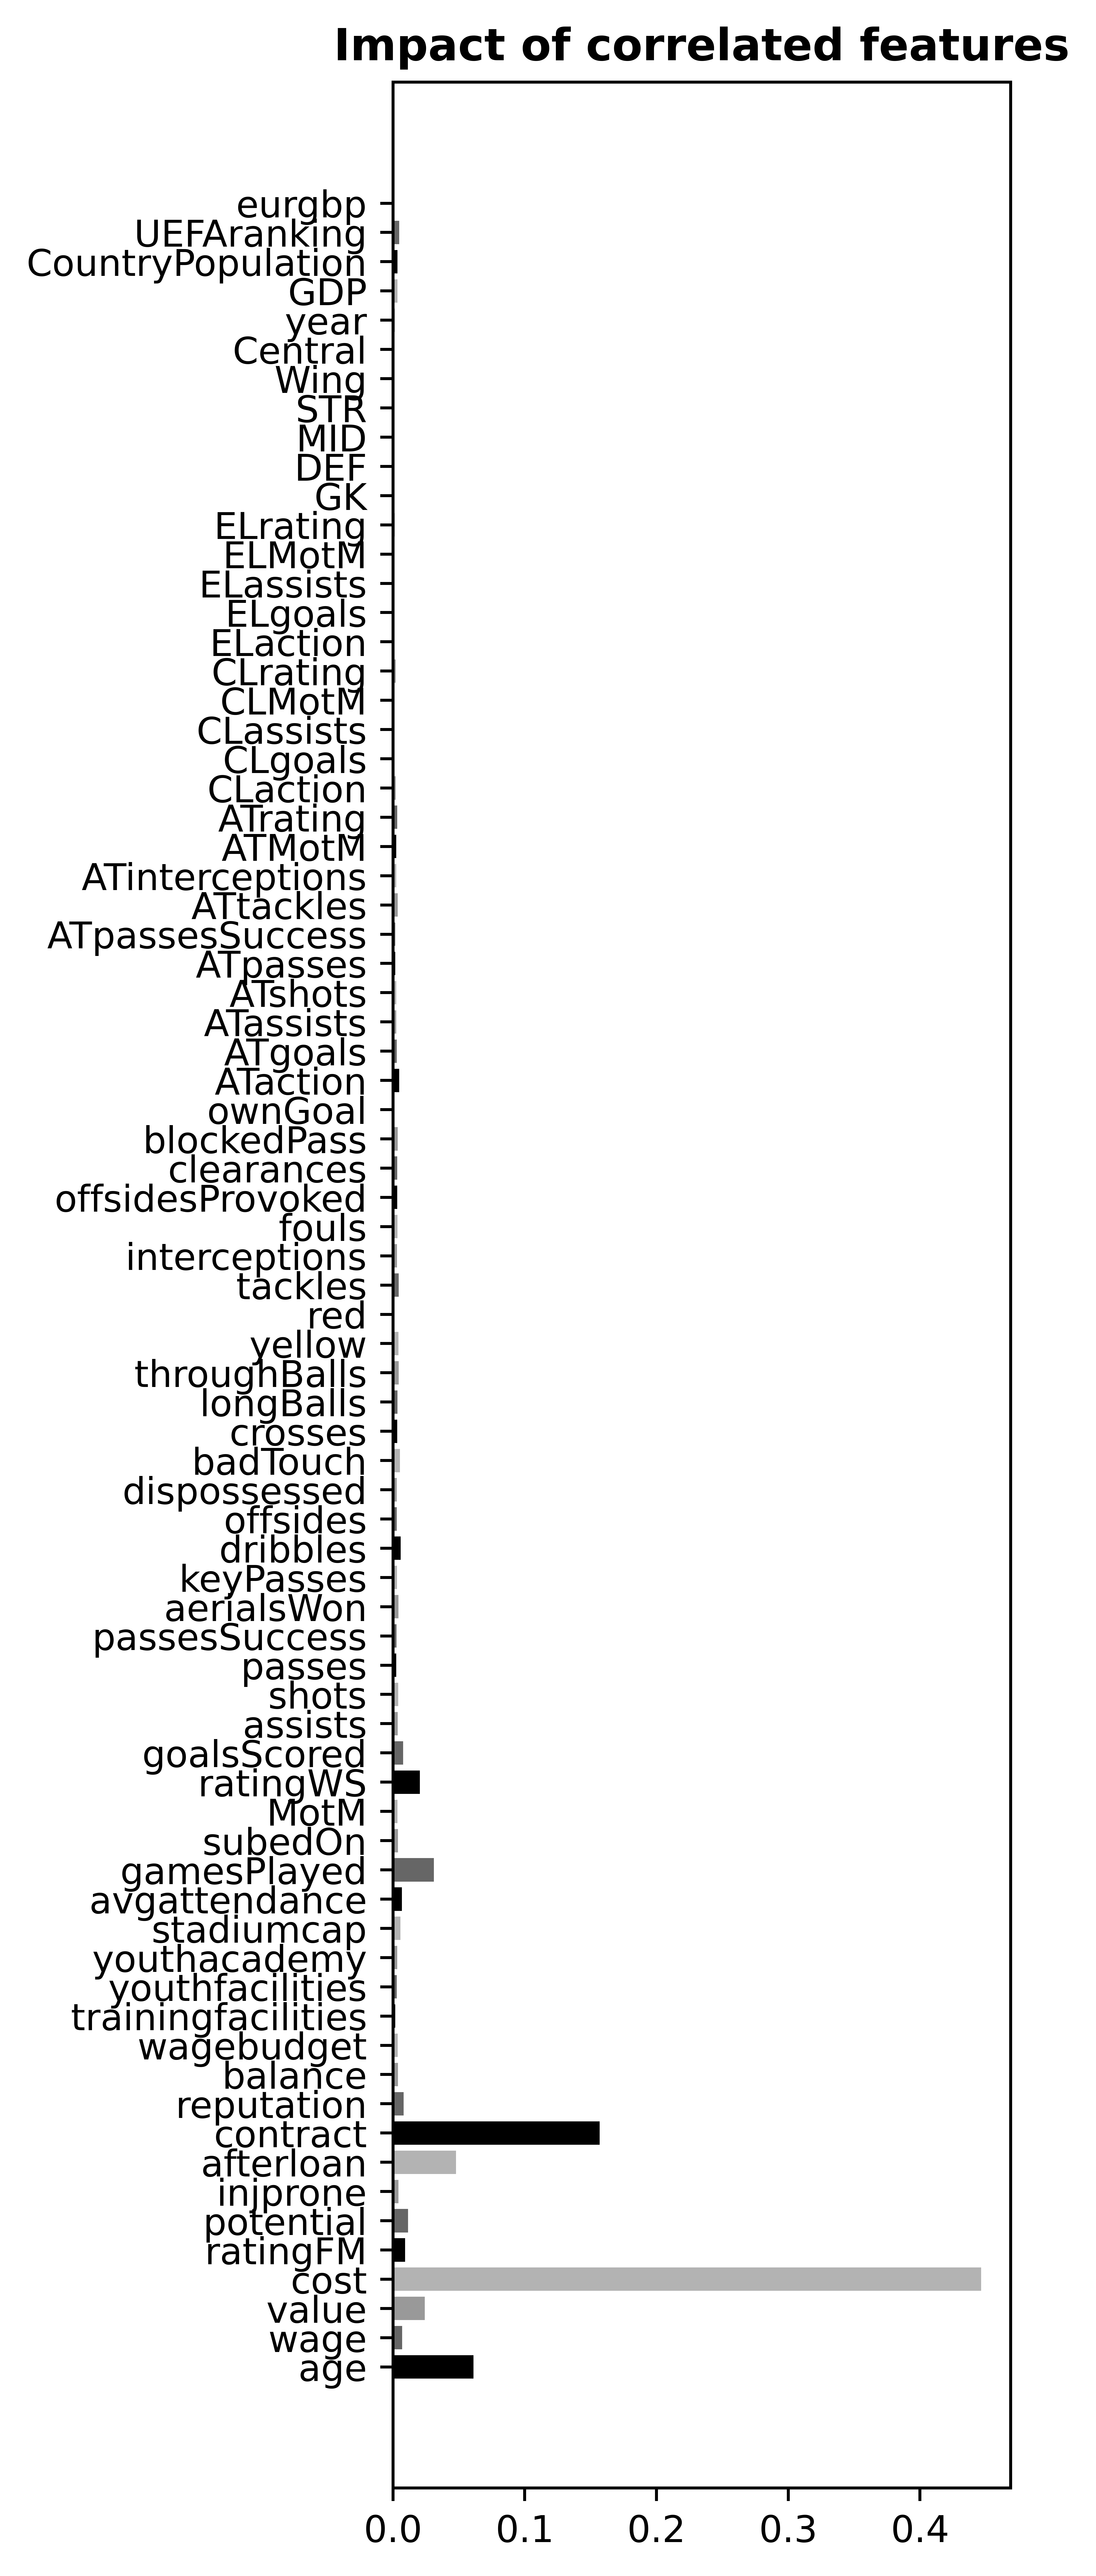

In [6]:
plt.style.use('grayscale')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 1080
plt.rcParams['figure.figsize'] = (3,12)

for i, param in enumerate(features):
    plt.barh(param, feature_importances[i])
plt.title('Impact of correlated features', fontweight='bold')
plt.savefig('img/007-1ImpactCorrelatedFeatures.eps', format = 'eps')

In [7]:
for i, param in enumerate(features):
    print(param, feature_importances[i])

age 0.061069301392212345
wage 0.0069335238601626464
value 0.02411048689035172
cost 0.4464219311075624
ratingFM 0.009152573712969238
potential 0.011458417242471802
injprone 0.004125602647892264
afterloan 0.04784417982135045
contract 0.1569900500857435
reputation 0.008062502521839961
balance 0.0037590210026702967
wagebudget 0.003662516700183858
trainingfacilities 0.001821702174011351
youthfacilities 0.0028822695351152466
youthacademy 0.0032492814509534553
stadiumcap 0.005734793052134372
avgattendance 0.006759940593639612
gamesPlayed 0.031129179718078655
subedOn 0.0037839090128156633
MotM 0.0034894881770803246
ratingWS 0.020426893617205937
goalsScored 0.007752412635846105
assists 0.003622344828647144
shots 0.003943605894202124
passes 0.0026065581350573253
passesSuccess 0.002741677669994274
aerialsWon 0.004259949956090796
keyPasses 0.0030377660762606696
dribbles 0.005802653484770202
offsides 0.0028962106545516388
dispossessed 0.0029178017042614628
badTouch 0.005297984435566637
crosses 0.00

In [7]:
features.remove('cost')
features.remove('value')

In [8]:
clf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
clf.fit(train_df[features], train_df['fee_log'])
feature_importances = clf.feature_importances_

Text(0.5, 1.0, 'Random Forest feature importance')

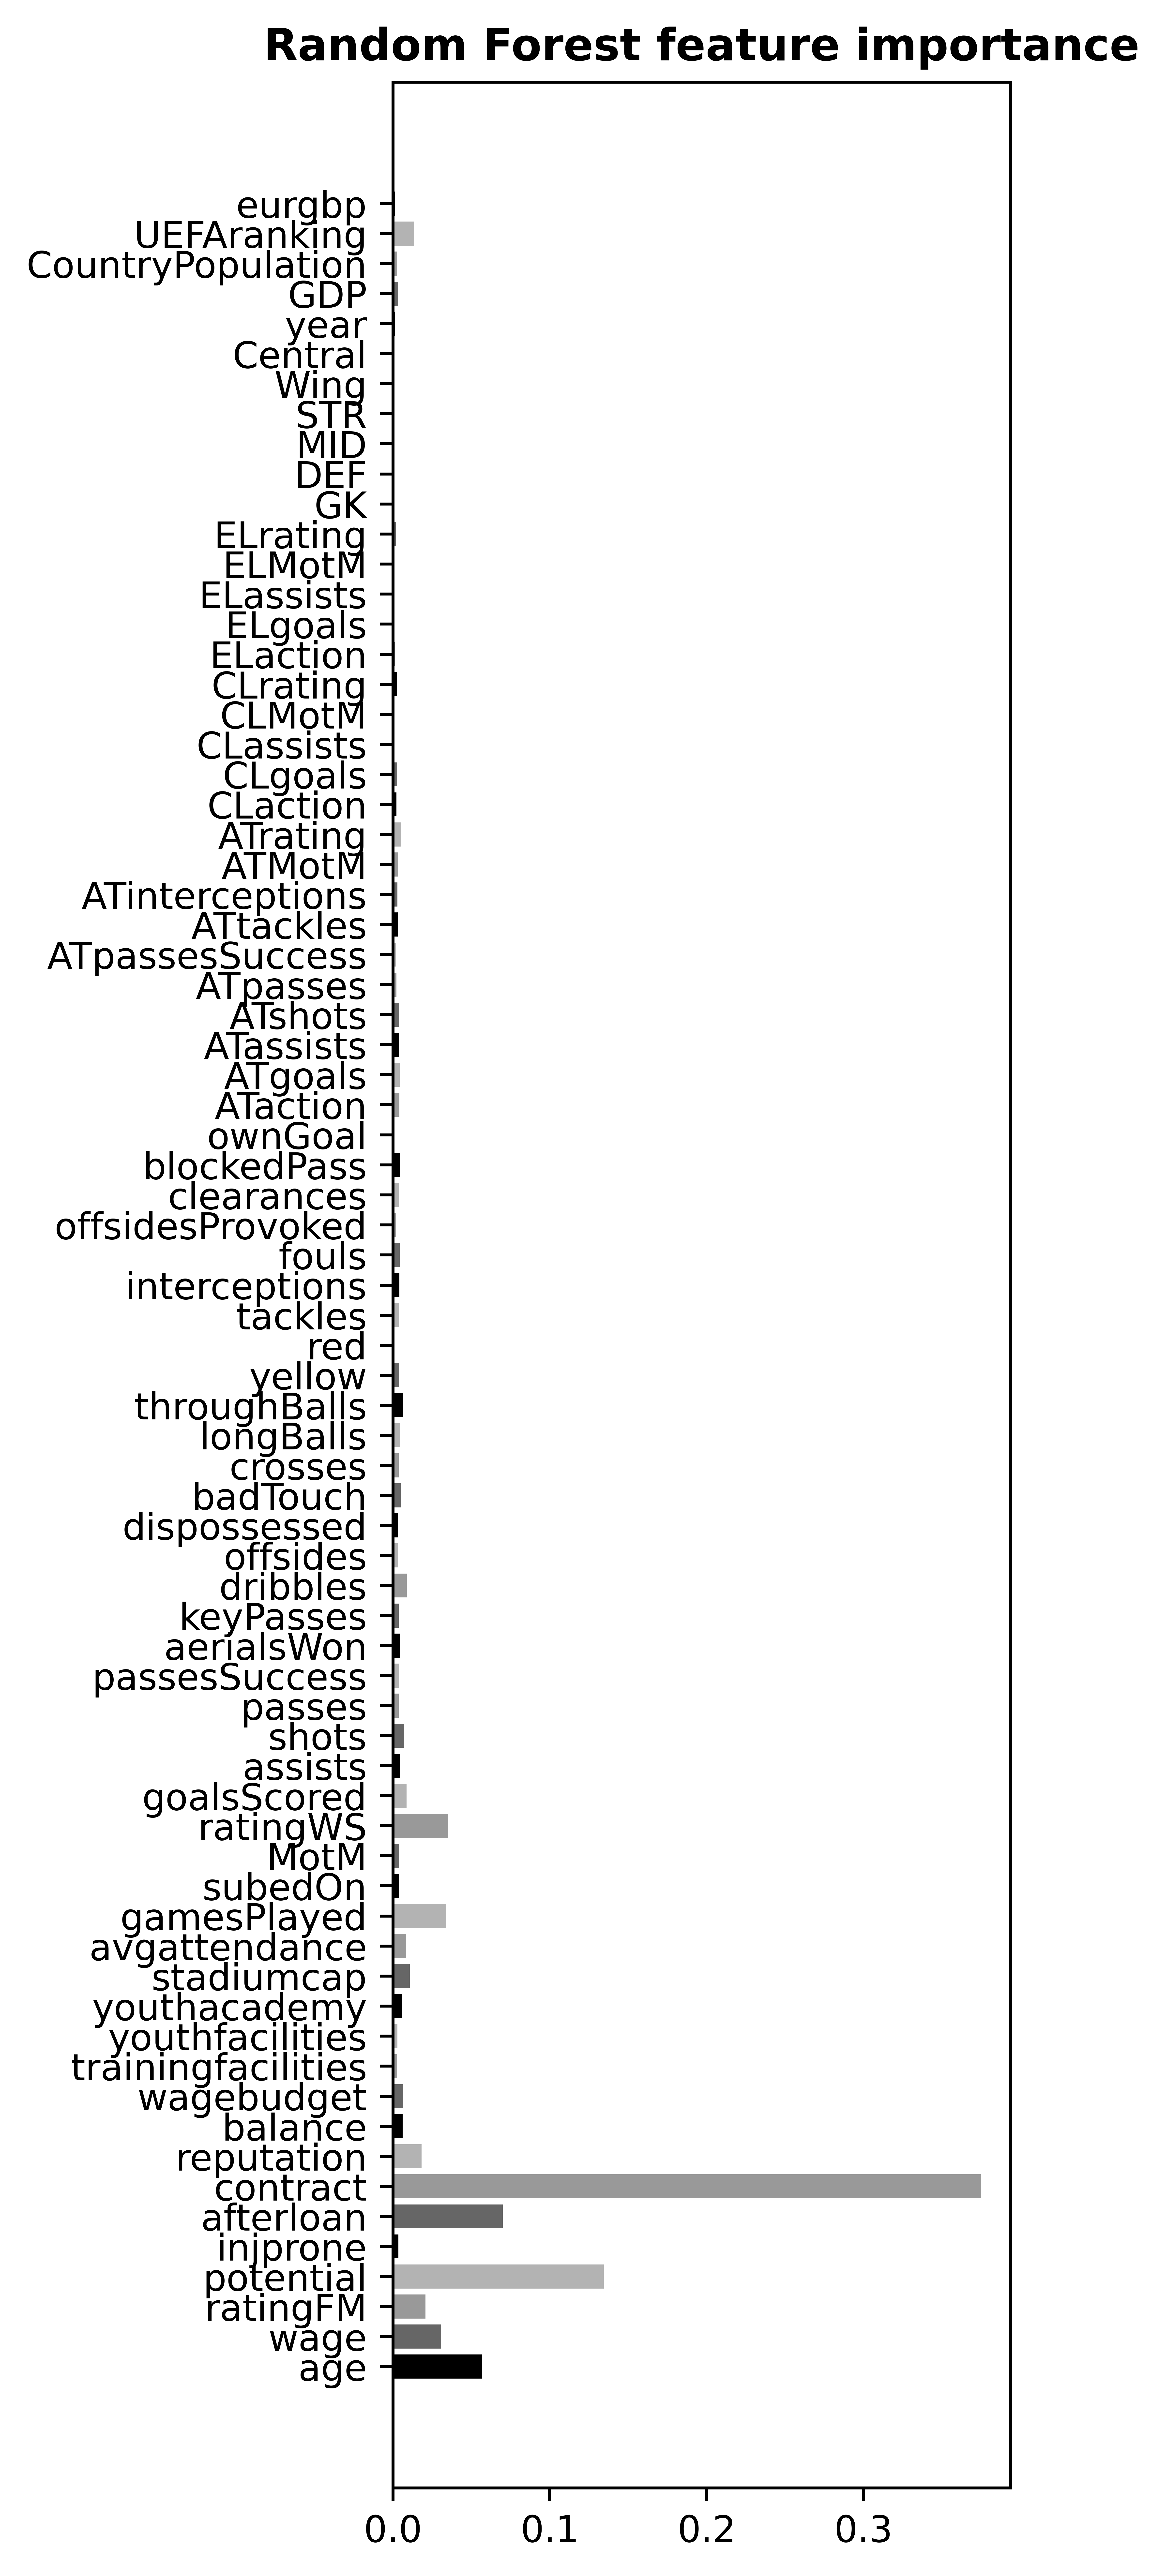

In [9]:
plt.style.use('grayscale')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 1080
plt.rcParams['figure.figsize'] = (3,12)

for i, param in enumerate(features):
    plt.barh(param, feature_importances[i])
plt.title('Random Forest feature importance', fontweight='bold')

In [10]:
## Bayesian optimization-based feature weighting
def objective_weighting(trial):
    weighted_df = train_df.copy()
    for i, feature in enumerate(features):
        weighted_df[feature] *= trial.suggest_uniform(feature, 0, 1)

    train_set = weighted_df.iloc[:int(internal_test_validation_split * len(weighted_df))]
    test_set = weighted_df.iloc[int(internal_test_validation_split * len(weighted_df)):]

    clf.fit(train_set[features], train_set['fee_log'])
    return metrics.mean_squared_error(clf.predict(test_set[features]), test_set['fee_log']) 

In [11]:
clf = KNeighborsRegressor(n_neighbors=30, n_jobs=-1)
study = optuna.create_study()
study.optimize(objective_weighting, n_trials=1000)

In [12]:
study.best_trial.number

964

In [13]:
study.best_trial.params

{'age': 0.8441057020403446,
 'wage': 0.24202558008769956,
 'ratingFM': 0.7982450916048524,
 'potential': 0.20666070223522867,
 'injprone': 0.5034611908742067,
 'afterloan': 0.9544096323603269,
 'contract': 0.9156550490303946,
 'reputation': 0.8288764971664874,
 'balance': 0.2417259426078803,
 'wagebudget': 0.85138239492961,
 'trainingfacilities': 0.916447927632877,
 'youthfacilities': 0.593073086420649,
 'youthacademy': 0.26362595151508106,
 'stadiumcap': 0.1706367566423878,
 'avgattendance': 0.04858802608228662,
 'gamesPlayed': 0.9447553644688905,
 'subedOn': 0.4608043602670682,
 'MotM': 0.03168438941134874,
 'ratingWS': 0.6672355662318117,
 'goalsScored': 0.20098598938453446,
 'assists': 0.38052114079497273,
 'shots': 0.7685145309689684,
 'passes': 0.2060850801400514,
 'passesSuccess': 0.8475984337439098,
 'aerialsWon': 0.07426615104675999,
 'keyPasses': 0.37276296804932335,
 'dribbles': 0.033551914116478884,
 'offsides': 0.20716826076239084,
 'dispossessed': 0.09225181087300072,
 'b

In [14]:
plt.style.use('grayscale')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 1080
plt.rcParams['figure.figsize'] = (10,12)

f, (a0, a2, a1) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [7, 1, 7]})
for i, param in enumerate(features):
    a0.barh(param, -study.best_trial.params[param])
    a1.barh(param, feature_importances[i])
    a2.barh(param, 0)
    a2.text(0, param, param, ha='center', va='center')
a0.set_yticks([])
a0.set_xlabel('Bayesian Weighting', fontweight='bold')
a1.set_yticks([])
a1.set_xlabel('Random Forest', fontweight='bold')
a2.set_xticks([])
a2.set_yticks([])
a2.axis('off')
a2.set_title('Comparing Bayesian Weighting vs Random Forest feature importance', fontweight='bold')
plt.tight_layout()
plt.savefig('img/007-2BayesWvsRFfi.eps', format = 'eps')